<a href="https://colab.research.google.com/github/deltorobarba/sciences/blob/master/quantum_chemistry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Quantum Chemistry Simulations on H₂ and NH₃ with VQE and UCCSD**

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_5000.png)

Let us simulates a quantum chemistry algorithm (VQE) using CUDA-Q on a GPU, targeting the ground state energy of a molecule (like hydrogen H₂) via a variational quantum eigensolver (VQE) with a UCCSD ansatz and a classical optimizer (COBYLA).


#### <font color="blue">**Step 1: Install Libraries and Dependencies**

In [ ]:
# Check access to nvidia GPUs
!nvidia-smi

Sun May 25 13:56:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   37C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
#!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/cuda-keyring_1.0-1_all.deb
#!dpkg -i cuda-keyring_1.0-1_all.deb
#!apt-get update
#!apt-get -y install libcublas-11-8 libcusolver-11-8 cuda-cudart-11-8
#%pip install cuda-quantum

In [ ]:
import numpy as np
print(np.__version__)

2.0.2


Check which NumPy is installed. One of the dependencies of CUDA-Q is trying to use 'np.string_' which was removed in NumPy 2.0, and you will get an error later *AttributeError: `np.string_` was removed in the NumPy 2.0 release. Use `np.bytes_`*. We need to downgrade np.

In [ ]:
# Force install NumPy < 2.0
!pip install numpy==1.26.4 --force-reinstall -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 120.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


Important: After installing, you **MUST restart your kernel/runtime before running your code again.** (in Colab: Runtime → Restart runtime(


In [ ]:
import numpy as np
print(np.__version__)  # Should show 1.26.4

1.26.4


In [ ]:
!pip install openfermionpyscf==0.5 matplotlib==3.8.4 scipy==1.14.0 -q
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 133.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.1/41.1 MB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 MB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 102.6 MB/s eta 0:00:00


In [ ]:
!pip install cudaq -q
import cudaq
print(cudaq.__version__)
!pip show cudaq

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.6/124.6 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 123.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 114.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 85.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.3/202.3 MB 4.7 MB/s eta 0:00:00
CUDA-Q Version 0.11.0 (https://github.com/NVIDIA/cuda-quantum f5cc3bb1d85abcf1f642f4ddd20ad08bc1d4d200)
Name: cudaq
Version: 0.11.0
Summary: Python bindings for the CUDA-Q toolkit for heterogeneous quantum-classical workflows.
Home-page: https://developer.nvidia.com/cuda-q
Author: NVIDIA Corporation & Affiliates
Author-email: 
License: Apache License Version 2.0

Copyright (c) 2023 - 2025 

#### <font color="blue">**Step 2: Quantum Simulation of Ground State Energy for Hydrogen molecule H₂**

Let us start with a small molecule: H₂ (hydrogen). This has:
* 2 hydrogen atoms in a linear chain
* distance: 0.7474 Å apart
* simple diatomic molecule
* geometry: H--H

I start with the tutorial from [CUDA-Q Tutorials Variational Quantum Eigensolver](https://nvidia.github.io/cuda-quantum/0.7.1/examples/python/tutorials/vqe.html). I will provide a few more details to describe the process. Later, I will compare the result with a classical computational chemistry simulation (and explain the difference), and then I will show how we can simulate larger molecules with this quantum algorithms, but using multi-node and multi-GPU distribution.

In [ ]:
###############################
# GPU backend for simulation
###############################

# Single precision
cudaq.set_target("nvidia")

# Double precision
#cudaq.set_target("nvidia-fp64")

In [ ]:
###############################
# Molecule and Basis Set
###############################

# Number of hydrogen atoms.
hydrogen_count = 2

# Distance between the atoms in Angstroms.
bond_distance = 0.7474

# Define a linear chain of Hydrogen atoms
geometry = [('H', (0, 0, i * bond_distance)) for i in range(hydrogen_count)]

# We use STO-3G basis set and build the electronic Hamiltonian
molecule, data = cudaq.chemistry.create_molecular_hamiltonian(
    geometry, 'sto-3g', 1, 0)

electron_count = data.n_electrons
qubit_count = 2 * data.n_orbitals

In [ ]:
###############################
# Resource Requirements
###############################

# This is important to define the distribution strategy (# of GPUs and nodes)
print(f"Electron count: {electron_count}")
print(f"Qubit count: {qubit_count}")
print(f"Number of orbitals: {data.n_orbitals}")

Electron count: 2
Qubit count: 4
Number of orbitals: 2


* The problem of interest here is a chain of hydrogen atoms seperated along the z-axis at a fixed interval called the bond distance.

* The interatomic electrostatic forces due to the electrons and protons and the shielding by the neutrons creates a chemical system whose energy can be minimised to find a stable configuration.

* Let us first begin by defining the molecule and other metadata about the problem.

In [ ]:
###############################
# Kernel and Ansatz (VQE)
###############################

# Quantum kernel prepares Hartree-Fock state by applying X gates to electrons and UCCSD ansatz with parameters thetas
# Unitary Coupled-Cluster Singles and Doubles (UCCSD) captures electronic correlations well, often used in quantum chemistry
# Alternatives: Nelder-Mead vs gradient-based etc

@cudaq.kernel
def kernel(thetas: list[float]):

    qubits = cudaq.qvector(qubit_count)

    for i in range(electron_count):
        x(qubits[i])

    cudaq.kernels.uccsd(qubits, thetas, electron_count, qubit_count)

parameter_count = cudaq.kernels.uccsd_num_parameters(electron_count,
                                                     qubit_count)

In [ ]:
###############################
# Optimizer
###############################

# COBYLA (Constrained Optimization BY Linear Approximations) for minimization of expected energy of molecule
# Gradient-free classical optimizer, well-suited for noisy landscapes (like those from VQE)

optimizer = cudaq.optimizers.COBYLA()

# 'cudaq.vqe' executes Variational Quantum Eigensolver (VQE)
# Internally loops over parameters, evaluates energy, optimizes. Returns lowest energy and optimal parameters
energy, parameters = cudaq.vqe(kernel,
                               molecule,
                               optimizer,
                               parameter_count=parameter_count)

print(f"VQE minimum energy for H₂: {energy} Hartree")

VQE minimum energy for H₂: -1.1371740035195186 Hartree


The VQE result of '-1.1371740035195186' is in so-called 'Hartree'. These are atomic units used for constructing the molecular Hamiltonian with the quantum chemistry backend `cudaq.chemistry.create_molecular_hamiltonian(...)`.

Even though we are doing a quantum variational calculation, the observable (the Hamiltonian) is derived from the same electronic structure Hamiltonian as classical Hartree-Fock SCF, which is typically expressed in Hartrees:

> $H = \sum_{pq} h_{pq} a_p^\dagger a_q + \frac{1}{2} \sum_{pqrs} h_{pqrs} a_p^\dagger a_q^\dagger a_r a_s$

where $h_{pq}$, $h_{pqrs}$ are integrals in Hartree units.


This takes one second to calculate on a single L4 GPU. So we don't need multi GPU or multi-node resources for distributed computation.

#### <font color="blue">**Step 3: Classical Simulation of Ground State Energy for Hydrogen molecule H₂**

Before we move on to large molecules, let us hold on for a second and compare our quantum computational simulation with a standard classical computational simulation. We will notice a difference between both results and this it important to understand why.

converged SCF energy = -1.12870009355644


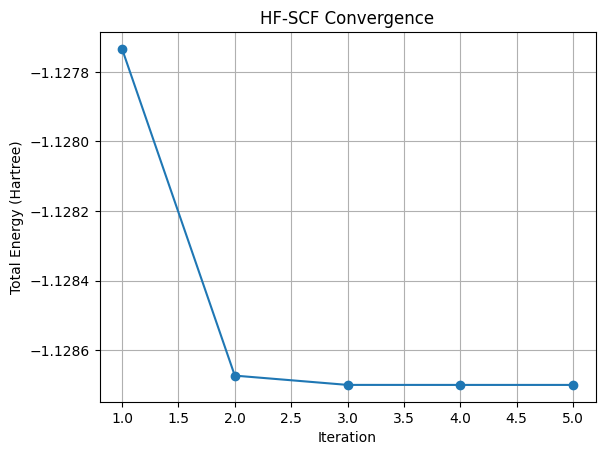

HF-SCF energy for H2: -1.1287000935564417 Hartree


In [ ]:
###############################
# Classical Computational Chemistry
###############################

# Let us compare the results from the quantum computational chemistry approach with a classical
# We use Hartree-Fock SCF (Slater Determinant-based Hartree-Fock Hamiltonian)

# Define hydrogen (H2) molecule
from pyscf import gto
mol = gto.Mole()
mol.atom = '''
    H  0.00 0.00  0.00
    H  0.00 0.00  0.74
'''

# First, ensure you have the PySCF package installed
from pyscf import gto, scf
import matplotlib.pyplot as plt

# Step 1: Define the molecule using gto.M() function
mol = gto.M(
    atom = mol.atom,
    basis = 'cc-pvdz',  # Use a common basis set, good balance between accuracy and computational cost
)

# Step 2: Perform a HF-SCF calculation using Restricted Hartree-Fock (RHF) method

# scf.RHF for a restricted Hartree-Fock calculation for a closed-shell system (H₂O)
mf = scf.RHF(mol)

# Store convergence data
conv_data = []

# Callback function to collect convergence information
# (callback function captures energy values at each iteration to track the convergence process)
def callback(envs):
    conv_data.append(envs['e_tot'])

# Set the callback directly on the mf object
mf.callback = callback

# Perform HF calculation
energy_classical = mf.kernel()

# Extract energy values and iteration numbers
energies = conv_data
iterations = range(1, len(energies) + 1)

# Plot the convergence
plt.plot(iterations, energies, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Total Energy (Hartree)')
plt.title('HF-SCF Convergence')
plt.grid(True)
plt.show()

print(f"HF-SCF energy for H2: {energy_classical} Hartree")

In [ ]:
print(f"Quantum Simulation for H2: {energy} Hartree")
print(f"Classic Simulation for H2: {energy_classical} Hartree")
print(f"Correlation Energy for H2: {energy_classical - energy} Hartree (Classical - Quantum)")

Quantum Simulation for H2: -1.1371740035195186 Hartree
Classic Simulation for H2: -1.1287000935564417 Hartree
Correlation Energy for H2: 0.008473909963076842 Hartree (Classical - Quantum)


The **classical simulation** is using 'Restricted Hartree-Fock (RHF)'. This is so-called a 'mean-field method' that uses a single Slater determinant to approximate the ground state. The result is:

> $E_{\text{HF}} = -1.1287 \ \text{Hartree}$

This approach ignores electron correlation beyond exchange interactions for computational efficiency.

The **quantum simulation** uses VQE with a UCCSD ansatz, which goes beyond Hartree-Fock, because it captures electron correlation by including excited Slater determinants in a variational way. This approximates so-called 'Full Configuration Interaction (FCI)' more closely and gives the more exact solution in the chosen basis. The result is:

> $E_{\text{VQE}} \approx -1.1372 \ \text{Hartree}$
* This is lower than the HF energy, as expected.

The difference of

> $\Delta E = E_{\text{HF}} - E_{\text{VQE}} \approx 0.0085 \ \text{Hartree}$

is the correlation energy captured by the UCCSD ansatz but missed by Hartree-Fock. So the quantum result is more accurate, assuming the ansatz is expressive enough and optimization converges well.

Running a full configuration interaction (FCI) for comparison would give us the exact ground state energy in the basis set and confirm that the VQE is close to the true minimum.

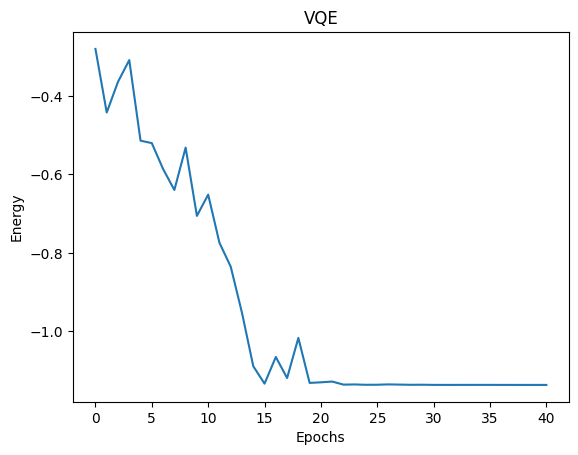

In [ ]:
###############################
# Control and Diagnostics
###############################

# We can also integrate popular libraries like scipy with CUDA-Q
# This is re-doing what cudaq.vqe(...) already did, but
# This is an independent run of VQE, entirely manual:
# We directly minimize the cost function.
# Use the same optimizer ("COBYLA").
# Track the optimization via the callback.


# Define a function to minimize
def cost(theta):

    exp_val = cudaq.observe(kernel, molecule, theta).expectation()

    return exp_val

# exp_vals records energy after each optimization step, used to plot convergence curve
exp_vals = []


def callback(xk):
    exp_vals.append(cost(xk))


# Initial variational parameters.
np.random.seed(42)
x0 = np.random.normal(0, np.pi, parameter_count)

# Manual optimization with SciPy
result = minimize(cost,
                  x0,
                  method='COBYLA',
                  callback=callback,
                  options={'maxiter': 40})

plt.plot(exp_vals)
plt.xlabel('Epochs')
plt.ylabel('Energy')
plt.title('VQE')
plt.show()

#### <font color="blue">**Step 4: Quantum Simulation of Ground State Energy for Ammonia molecule NH₃**

###### <font color="blue">*Step 4.1: Run quantum simulation on single GPU*

Now we are ready to step up the game to simulate a larger molecule which requires more resources for quantum simulation.

**Previously, simulating the quantum algorithm for a hydrogen molecule is easy. Hydrogen H₂ has:**

* 2 hydrogen atoms in a linear chain
* distance: 0.7474 Å apart
* simple diatomic molecule
* geometry: H--H

From our resource requirements code above we saw that his molecular structure had only an electron count = 2 with number of orbitals = 2. Simulation the ground state energy H₂ with a quantum algorithm requires only ~4 qubits, because: 2 orbitals × 2 spin states. This is fairly easy to simulate on a single GPU.

**Now let's create NH₃ (ammonia). This molecule is larger as it has:**
* 1 nitrogen atom + 3 hydrogen atoms
* Pyramidal structure
* Much more complex molecule
* Geometry: N at center with 3 H atoms around it

The main differences between hydrogen H₂ and ammonia NH₃ are:
* Different atoms: H₂ vs NH₃
* Different complexity: 2 atoms vs 4 atoms
* Different electron count: H₂ has 2 electrons, NH₃ has 10 electrons (N has 7, each H has 1)
* Different qubit requirements: H₂ needs fewer qubits than NH₃

**NH₃ has an electron count of 10 and with 8 orbitals. We will need 16 qubits for quantum simulation.**

In [ ]:
###############################
# GPU backend for simulation
###############################

# Single precision
cudaq.set_target("nvidia")

# Double precision
#cudaq.set_target("nvidia-fp64")

In [ ]:
###############################
# Molecule and Basis Set
###############################

# Number of hydrogen atoms.
hydrogen_count = 2

# Define ammonia molecule
geometry = [
    ["N", (0.0000, 0.0000, 0.0000)], # Nitrogen
    ["H", (0.0000, 0.0000, 1.0120)], # Hydrogen 1
    ["H", (0.9377, 0.0000, -0.3430)], # Hydrogen 2
    ["H", (-0.9377, 0.0000, -0.3430)] # Hydrogen 3
    ]

# We use STO-3G basis set and build the electronic Hamiltonian
molecule, data = cudaq.chemistry.create_molecular_hamiltonian(
    geometry, 'sto-3g', 1, 0)

electron_count = data.n_electrons
qubit_count = 2 * data.n_orbitals

In [ ]:
###############################
# Resource Requirements
###############################

# This is important to define the distribution strategy (# of GPUs and nodes)
print(f"Electron count: {electron_count}")
print(f"Qubit count: {qubit_count}")
print(f"Number of orbitals: {data.n_orbitals}")

Electron count: 10
Qubit count: 16
Number of orbitals: 8


This calculation is going to take 1 hours if we proceed with our calculation from above on a single L4 GPU . This means we need to think how we distribute the optimization.

In [ ]:
###############################
# Kernel and Ansatz (VQE)
###############################

# Quantum kernel prepares Hartree-Fock state by applying X gates to electrons and UCCSD ansatz with parameters thetas
# Unitary Coupled-Cluster Singles and Doubles (UCCSD) captures electronic correlations well, often used in quantum chemistry
# Alternatives: Nelder-Mead vs gradient-based etc

@cudaq.kernel
def kernel(thetas: list[float]):

    qubits = cudaq.qvector(qubit_count)

    for i in range(electron_count):
        x(qubits[i])

    cudaq.kernels.uccsd(qubits, thetas, electron_count, qubit_count)

parameter_count = cudaq.kernels.uccsd_num_parameters(electron_count,
                                                     qubit_count)

In [ ]:
###############################
# Optimizer
###############################

# COBYLA (Constrained Optimization BY Linear Approximations) for minimization of expected energy of molecule
# Gradient-free classical optimizer, well-suited for noisy landscapes (like those from VQE)

optimizer = cudaq.optimizers.COBYLA()

# 'cudaq.vqe' executes Variational Quantum Eigensolver (VQE)
# Internally loops over parameters, evaluates energy, optimizes. Returns lowest energy and optimal parameters
energy, parameters = cudaq.vqe(kernel,
                               molecule,
                               optimizer,
                               parameter_count=parameter_count)

print(f"VQE minimum energy for NH₃: {energy} Hartree")

VQE minimum energy for NH₃: -55.43534589340438 Hartree


DFT energy for Ammonia (NH₃) using b3lyp: -56.55414643336473 Hartree

In [ ]:
from pyscf import gto

# Define the molecule
mol = gto.Mole()
mol.atom = '''
    N  0.0000  0.0000  0.2000
    H  0.0000  0.9433 -0.2000
    H  0.8165 -0.4717 -0.2000
    H -0.8165 -0.4717 -0.2000
'''

# Name
molecule = 'Ammonia (NH₃)'

# Set basis set
mol.basis = 'sto-3g' # Alternatively: sto-3g, cc-pvdz,6-31G

from pyscf import dft

# Define the molecule
mol.atom = mol.atom
mol.basis = mol.basis
mol.verbose = 4
mol.build()

# Perform a DFT calculation part I
mf = dft.RKS(mol)
mf.xc = 'b3lyp'

### Store convergence data
conv_data = []

### Callback function to collect convergence information
def callback(envs):
    conv_data.append(envs['e_tot'])

### Set the callback directly on the mf object
mf.callback = callback

# Perform a DFT calculation part II
energy = mf.kernel()

# Extract energy values and iteration numbers
energies = conv_data
iterations = range(1, len(energies) + 1)

print(f"DFT energy for {molecule} using {mf.xc}: {energy} Hartree")

###### <font color="blue">*Step 4.2: Understand Resource Requirements*<font color="blue">

We are performing quantum chemistry simulations using VQE with a UCCSD ansatz on molecules like H₂ and NH₃. While H₂ is fast to simulate, NH₃ requires hours even on a high-end GPU, because the quantum state size and circuit depth grow exponentially with the number of qubits (16+ for NH₃). To make simulation tractable, we need distributed quantum simulation strategies.

**Challenge for scaling is the state vector size:**
* For n qubits, the state vector has $2^n$ complex amplitudes.
* Each amplitude is typically 16 bytes (complex128: 8 bytes real + 8 bytes imag).
* For NH₃ (16 qubits):

> $2^{16} \times 16\ \text{bytes} = 1,048,576\ \text{bytes} = 1\ \text{MB}$

→ This seems small, but:
* Circuit gates require global access to amplitudes, and
* As qubit count grows, memory and communication become the bottleneck (every additional qubit doubles memory requirements)

**A very rough rule of thumb for resource-based regimes is:**
* 12-16 (e.g., H₂, NH₃) qubits, best: Single node with multiple GPUs
* 17-24 qubits, best is Multi-GPU, possibly multi-node
* 25+ qubits, best is Distributed across multiple nodes
* max is around 43 qubits that can be simulated in classical HPC

But how are these numbers derived? There is actually not a single root cause, but various, with different implications when simulating quantum algorithms:

**1. State Vector Storage**
* Distribution Strategy: Data Parallel
* Pattern: Each GPU stores a subset of the full state vector.
* Communication: Minimal for storage; needed when computing global expectation values or applying nonlocal gates.
* Scaling: Perfectly scalable until memory runs out. The challenge lies not in holding the state but in applying gates and observing it.

**2. Gate Operations (Circuit Execution)**
* Distribution Strategy: Data + Model Parallel
* Pattern:
  * Single-qubit gates: Local operations on the amplitude chunk — no communication.
  * Two-qubit gates (like CNOT): Span multiple chunks → require nearest-neighbor or all-to-all communication.
* Communication Cost: High for gates that entangle distant qubits.
* Scaling:
  * Good for shallow, local circuits.
  * Degrades for deep, highly entangled circuits (as in UCCSD for NH₃).

**3. VQE Optimization Loop**
* Distribution Strategy: Parameter Parallel (or functional parallelism)
* Pattern:
  * Each GPU evaluates energy for a different parameter set (like in SPSA or grid search).
  * Gradients or losses can be reduced and aggregated.
* Communication: Moderate — parameter broadcast, gradient collection.
* Scaling: Limited by the fact that VQE is sequential:
  * You update parameters → evaluate energy → repeat.
  * True parallelism is in batching expectation evaluations, not the optimizer itself.

**4. Expectation Value Calculation**
* Distribution Strategy: Data Parallel
* Pattern:
  * Each GPU evaluates a subset of Pauli terms.
  * This is often the most parallelizable part.
* Communication: Just one reduction (sum) after local evaluations.
* Scaling: Excellent — practically very parallel.

| Module               | Parallel Strategy     | Communication Pattern           | Scaling Behavior                    |
| -------------------- | --------------------- | ------------------------------- | ----------------------------------- |
| State Vector Storage | Data Parallel         | All-reduce (for global ops)     | Excellent until memory limit        |
| Gate Execution       | Data + Model Parallel | Nearest neighbor / all-to-all   | Moderate, CNOT-heavy circuits limit |
| VQE Optimization     | Parameter Parallel    | Parameter broadcast, reduction  | Limited (serial bottleneck)         |
| Expectation Value    | Data Parallel         | Single reduction (sum of terms) | Excellent – embarrassingly parallel |

**So, how do we define a distribution strategy to optimize NH₃ simulation with 16 Qubits?**
* NH₃ may require evaluating 156 Pauli terms → With 4 GPUs: 39 terms per GPU = \~4x speedup in this step
* Use a Single Node with 4 GPUs:
   * NH₃ is small enough to fit on one node.
   * NVLink allows fast communication between GPUs (\~600 GB/s).
* Distribute Expectation Value Calculation:
   * Each GPU handles a subset of Pauli terms.
   * Nearly perfect parallelism with minimal communication.
* Parallelize State Vector + Single-Qubit Gates:
   * 60% of gates in UCCSD are single-qubit → perfect scaling.
   * Two-qubit gates are manageable over NVLink.
* But we avoid Multi-Node Unless Needed:
   * For NH₃, multi-node introduces overhead with little gain.
   * Memory (160 GB for 4 A100s) is more than enough for 16 qubits.


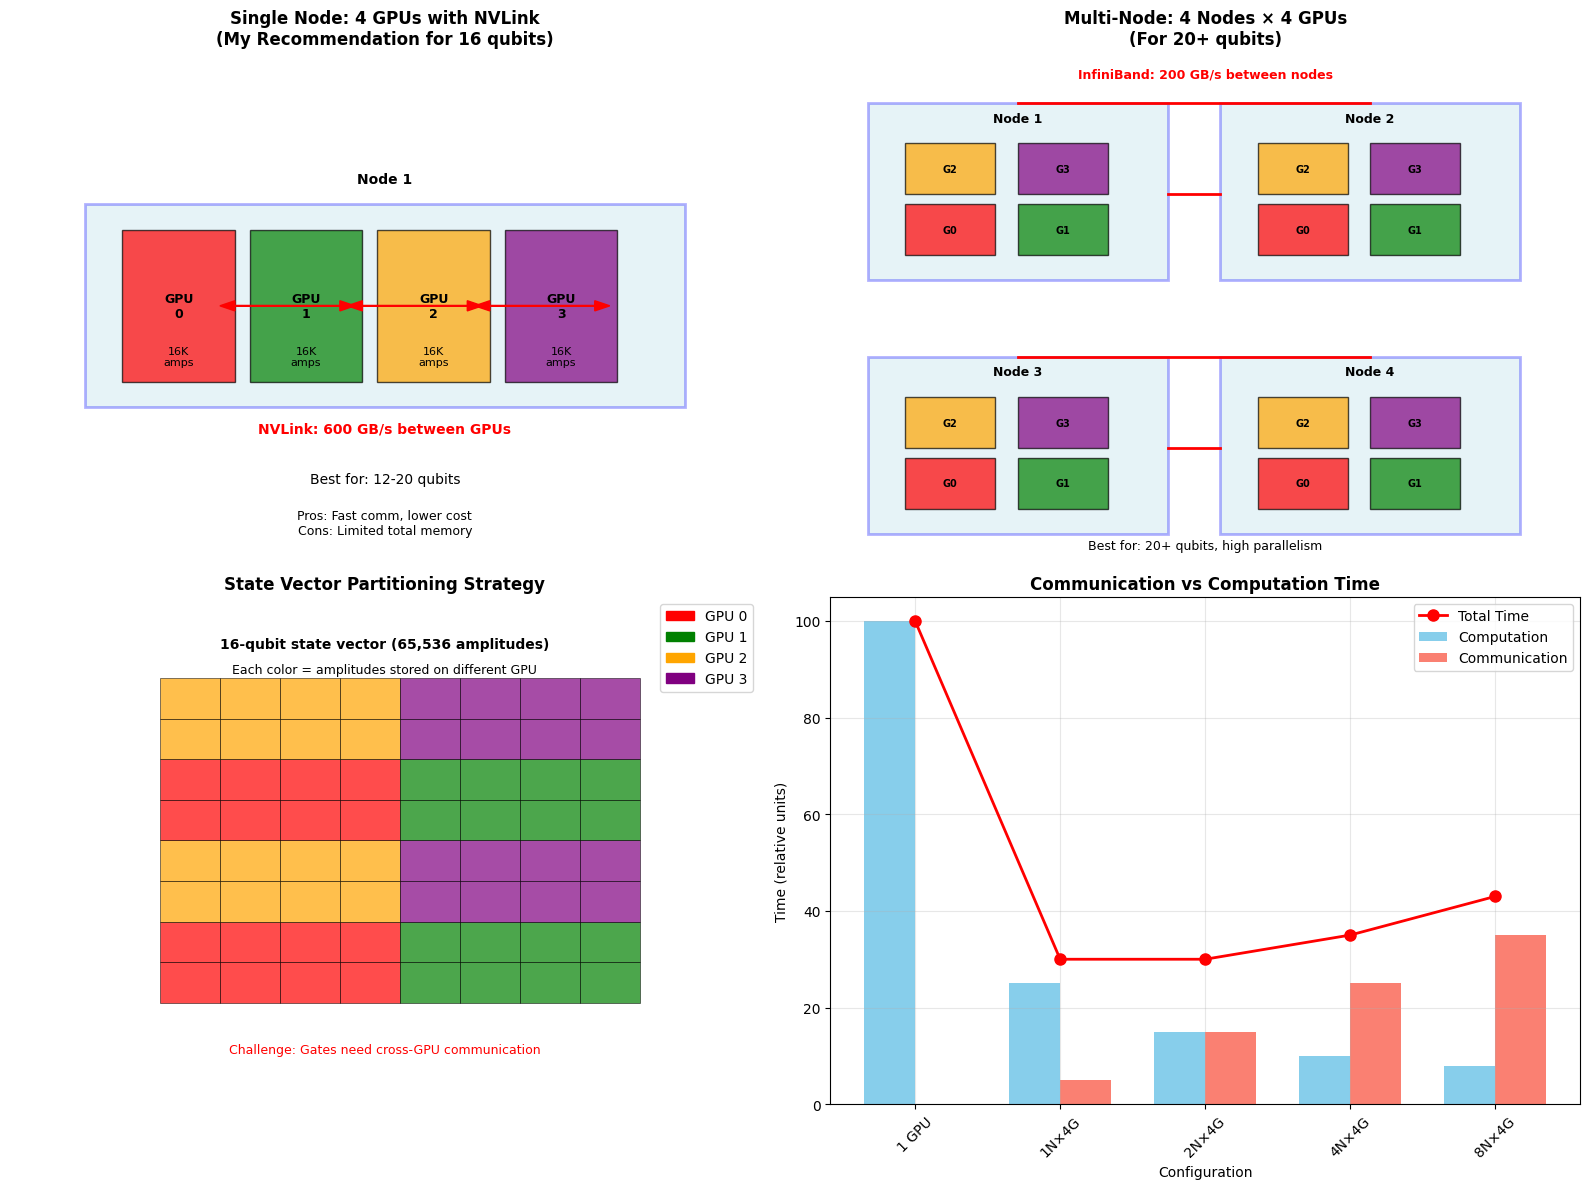

=== NH3 Molecule Specific Analysis ===
Current setup: T4 GPU, 2+ hours
Target: <30 minutes

Configuration Comparison:
--------------------------------------------------------------------------------

Current (T4):
  gpus: 1
  memory_per_gpu: 16 GB
  bandwidth: 320 GB/s
  estimated_time: 120+ min
  cost_per_hour: $0.35

Recommended: 1 Node × 4 A100:
  gpus: 4
  memory_per_gpu: 40 GB each
  bandwidth: 600 GB/s NVLink
  estimated_time: 15-25 min
  cost_per_hour: $14.68

Aggressive: 2 Nodes × 4 A100:
  gpus: 8
  memory_per_gpu: 40 GB each
  bandwidth: 600 GB/s intra + 200 GB/s inter
  estimated_time: 8-15 min
  cost_per_hour: $29.36

Overkill: 4 Nodes × 4 A100:
  gpus: 16
  memory_per_gpu: 40 GB each
  bandwidth: Complex topology
  estimated_time: 5-10 min
  cost_per_hour: $58.72

RECOMMENDATION FOR NH3 (16 qubits):
1 Node × 4 A100-40GB GPUs
- Sweet spot for performance vs cost
- NVLink provides fast inter-GPU communication
- Sufficient memory (160 GB total vs ~1 MB needed)
- Should achiev

In [ ]:
# @title Visual representation of how quantum states distribute across GPUs

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

def visualize_distribution_patterns():
    """Visualize different ways to distribute quantum state across GPUs"""

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Pattern 1: Single Node, Multiple GPUs (NVLink)
    ax1 = axes[0, 0]
    ax1.set_title("Single Node: 4 GPUs with NVLink\n(My Recommendation for 16 qubits)", fontsize=12, fontweight='bold')

    # Draw node
    node_rect = Rectangle((0.1, 0.3), 0.8, 0.4, linewidth=2, edgecolor='blue', facecolor='lightblue', alpha=0.3)
    ax1.add_patch(node_rect)
    ax1.text(0.5, 0.75, 'Node 1', ha='center', va='center', fontweight='bold')

    # Draw GPUs
    gpu_colors = ['red', 'green', 'orange', 'purple']
    for i in range(4):
        gpu_rect = Rectangle((0.15 + i*0.17, 0.35), 0.15, 0.3,
                           linewidth=1, edgecolor='black', facecolor=gpu_colors[i], alpha=0.7)
        ax1.add_patch(gpu_rect)
        ax1.text(0.225 + i*0.17, 0.5, f'GPU\n{i}', ha='center', va='center', fontsize=9, fontweight='bold')
        ax1.text(0.225 + i*0.17, 0.4, f'16K\namps', ha='center', va='center', fontsize=8)

    # Draw NVLink connections
    for i in range(3):
        ax1.arrow(0.3 + i*0.17, 0.5, 0.14, 0, head_width=0.02, head_length=0.02, fc='red', ec='red')
        ax1.arrow(0.44 + i*0.17, 0.5, -0.14, 0, head_width=0.02, head_length=0.02, fc='red', ec='red')

    ax1.text(0.5, 0.25, 'NVLink: 600 GB/s between GPUs', ha='center', fontsize=10, color='red', fontweight='bold')
    ax1.text(0.5, 0.15, 'Best for: 12-20 qubits', ha='center', fontsize=10)
    ax1.text(0.5, 0.05, 'Pros: Fast comm, lower cost\nCons: Limited total memory', ha='center', fontsize=9)

    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    ax1.axis('off')

    # Pattern 2: Multi-Node (InfiniBand)
    ax2 = axes[0, 1]
    ax2.set_title("Multi-Node: 4 Nodes × 4 GPUs\n(For 20+ qubits)", fontsize=12, fontweight='bold')

    node_positions = [(0.05, 0.55), (0.52, 0.55), (0.05, 0.05), (0.52, 0.05)]

    for node_idx, (x, y) in enumerate(node_positions):
        # Draw node
        node_rect = Rectangle((x, y), 0.4, 0.35, linewidth=2, edgecolor='blue', facecolor='lightblue', alpha=0.3)
        ax2.add_patch(node_rect)
        ax2.text(x + 0.2, y + 0.32, f'Node {node_idx+1}', ha='center', va='center', fontweight='bold', fontsize=9)

        # Draw GPUs in 2x2 grid
        for gpu_idx in range(4):
            gpu_x = x + 0.05 + (gpu_idx % 2) * 0.15
            gpu_y = y + 0.05 + (gpu_idx // 2) * 0.12
            gpu_rect = Rectangle((gpu_x, gpu_y), 0.12, 0.1,
                               linewidth=1, edgecolor='black', facecolor=gpu_colors[gpu_idx], alpha=0.7)
            ax2.add_patch(gpu_rect)
            ax2.text(gpu_x + 0.06, gpu_y + 0.05, f'G{gpu_idx}', ha='center', va='center', fontsize=7, fontweight='bold')

    # Draw InfiniBand connections between nodes
    connections = [((0.45, 0.72), (0.52, 0.72)), ((0.25, 0.9), (0.72, 0.9)),
                   ((0.45, 0.22), (0.52, 0.22)), ((0.25, 0.4), (0.72, 0.4))]

    for (x1, y1), (x2, y2) in connections:
        ax2.plot([x1, x2], [y1, y2], 'r-', linewidth=2)

    ax2.text(0.5, 0.95, 'InfiniBand: 200 GB/s between nodes', ha='center', fontsize=9, color='red', fontweight='bold')
    ax2.text(0.5, 0.02, 'Best for: 20+ qubits, high parallelism', ha='center', fontsize=9)

    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    ax2.axis('off')

    # Pattern 3: State Vector Partitioning
    ax3 = axes[1, 0]
    ax3.set_title("State Vector Partitioning Strategy", fontsize=12, fontweight='bold')

    # Draw state vector as grid
    state_size = 8  # Simplified 8x8 grid representing 2^16 amplitudes
    cell_size = 0.08
    start_x, start_y = 0.2, 0.2

    colors = ['red', 'green', 'orange', 'purple']

    for i in range(state_size):
        for j in range(state_size):
            gpu_id = (i // 2) * 2 + (j // 4)  # Assign chunks to different GPUs
            color = colors[gpu_id % 4]

            rect = Rectangle((start_x + j*cell_size, start_y + i*cell_size),
                           cell_size, cell_size, linewidth=0.5,
                           edgecolor='black', facecolor=color, alpha=0.7)
            ax3.add_patch(rect)

    # Legend
    legend_elements = [mpatches.Patch(color=colors[i], label=f'GPU {i}') for i in range(4)]
    ax3.legend(handles=legend_elements, loc='upper right')

    ax3.text(0.5, 0.9, '16-qubit state vector (65,536 amplitudes)', ha='center', fontsize=10, fontweight='bold')
    ax3.text(0.5, 0.85, 'Each color = amplitudes stored on different GPU', ha='center', fontsize=9)
    ax3.text(0.5, 0.1, 'Challenge: Gates need cross-GPU communication', ha='center', fontsize=9, color='red')

    ax3.set_xlim(0, 1)
    ax3.set_ylim(0, 1)
    ax3.axis('off')

    # Pattern 4: Communication Overhead
    ax4 = axes[1, 1]
    ax4.set_title("Communication vs Computation Time", fontsize=12, fontweight='bold')

    # Sample data for different configurations
    configs = ['1 GPU', '1N×4G', '2N×4G', '4N×4G', '8N×4G']
    computation_time = [100, 25, 15, 10, 8]  # Decreases with more GPUs
    communication_time = [0, 5, 15, 25, 35]  # Increases with distribution

    x = np.arange(len(configs))
    width = 0.35

    bars1 = ax4.bar(x - width/2, computation_time, width, label='Computation', color='skyblue')
    bars2 = ax4.bar(x + width/2, communication_time, width, label='Communication', color='salmon')

    ax4.set_ylabel('Time (relative units)')
    ax4.set_xlabel('Configuration')
    ax4.set_xticks(x)
    ax4.set_xticklabels(configs, rotation=45)
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    # Add total time line
    total_time = [c + comm for c, comm in zip(computation_time, communication_time)]
    ax4.plot(x, total_time, 'ro-', linewidth=2, markersize=8, label='Total Time')
    ax4.legend()

    plt.tight_layout()
    plt.savefig('quantum_distribution_patterns.png', dpi=300, bbox_inches='tight')
    plt.show()

def analyze_nh3_specific_recommendations():
    """Specific analysis for NH3 molecule"""

    print("=== NH3 Molecule Specific Analysis ===")
    print("Current setup: T4 GPU, 2+ hours")
    print("Target: <30 minutes")
    print()

    configurations = {
        "Current (T4)": {
            "gpus": 1,
            "memory_per_gpu": "16 GB",
            "bandwidth": "320 GB/s",
            "estimated_time": "120+ min",
            "cost_per_hour": "$0.35"
        },
        "Recommended: 1 Node × 4 A100": {
            "gpus": 4,
            "memory_per_gpu": "40 GB each",
            "bandwidth": "600 GB/s NVLink",
            "estimated_time": "15-25 min",
            "cost_per_hour": "$14.68"
        },
        "Aggressive: 2 Nodes × 4 A100": {
            "gpus": 8,
            "memory_per_gpu": "40 GB each",
            "bandwidth": "600 GB/s intra + 200 GB/s inter",
            "estimated_time": "8-15 min",
            "cost_per_hour": "$29.36"
        },
        "Overkill: 4 Nodes × 4 A100": {
            "gpus": 16,
            "memory_per_gpu": "40 GB each",
            "bandwidth": "Complex topology",
            "estimated_time": "5-10 min",
            "cost_per_hour": "$58.72"
        }
    }

    print("Configuration Comparison:")
    print("-" * 80)

    for config_name, details in configurations.items():
        print(f"\n{config_name}:")
        for key, value in details.items():
            print(f"  {key}: {value}")

    print("\n" + "="*60)
    print("RECOMMENDATION FOR NH3 (16 qubits):")
    print("1 Node × 4 A100-40GB GPUs")
    print("- Sweet spot for performance vs cost")
    print("- NVLink provides fast inter-GPU communication")
    print("- Sufficient memory (160 GB total vs ~1 MB needed)")
    print("- Should achieve 15-25 minute runtime")
    print("- Cost: ~$15/hour vs $0.35/hour (42x more, but 5-8x faster)")
    print("="*60)

# Run the analysis
if __name__ == "__main__":
    visualize_distribution_patterns()
    analyze_nh3_specific_recommendations()

###### <font color="blue">*Step 4.3: Set Up Google Cloud HPC Infrastructure*

First, create a cluster with GPU nodes

```
# gcp-hpc-cluster.yaml
apiVersion: compute/v1
kind: InstanceTemplate
metadata:
  name: quantum-sim-template
spec:
  machineType: a2-highgpu-4g  # 4x A100 GPUs per node
  # Alternative: a2-ultragpu-8g for 8x A100 GPUs
  
  disks:
  - boot: true
    initializeParams:
      sourceImage: projects/ml-images/global/images/c0-deeplearning-common-gpu-v20240125-debian-11
      diskSizeGb: 200
  
  networkInterfaces:
  - network: projects/[PROJECT_ID]/global/networks/default
    accessConfigs:
    - type: ONE_TO_ONE_NAT
  
  scheduling:
    preemptible: false  # Use non-preemptible for long quantum sims
  
  metadata:
    items:
    - key: install-nvidia-driver
      value: "True"
    - key: startup-script
      value: |
        #!/bin/bash
        # Install CUDA Quantum and MPI
        pip install cudaq mpi4py
        
        # Install NCCL for GPU communication
        wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64/cuda-keyring_1.0-1_all.deb
        dpkg -i cuda-keyring_1.0-1_all.deb
        apt update
        apt install -y libnccl2 libnccl-dev

---
# Create managed instance group
apiVersion: compute/v1
kind: InstanceGroupManager
metadata:
  name: quantum-sim-cluster
spec:
  baseInstanceName: quantum-node
  instanceTemplate: quantum-sim-template
  targetSize: 4  # Start with 4 nodes
  zone: us-central1-a
```

*Distributed CUDA-Q ImplementationDistributed Multi-GPU VQE Implementation*

```
#!/usr/bin/env python3
"""
Distributed Multi-GPU VQE for large molecular systems
Requires: mpirun -np <num_processes> python distributed_vqe.py
"""

import numpy as np
import cudaq
from mpi4py import MPI
import os
import time
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# MPI Setup
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

def setup_distributed_cudaq():
    """Configure CUDA-Q for distributed execution"""
    
    # Set GPU device based on local rank
    local_rank = rank % 4  # Assuming 4 GPUs per node
    os.environ['CUDA_VISIBLE_DEVICES'] = str(local_rank)
    
    # Use distributed GPU target
    if rank == 0:
        print(f"Setting up distributed simulation with {size} processes")
    
    # For large systems, use nvidia-mgpu target
    cudaq.set_target("nvidia-mgpu")
    # Alternative: cudaq.set_target("nvidia-fp64-mgpu") for double precision
    
    return local_rank

def create_nh3_molecule():
    """Create NH3 molecular Hamiltonian"""
    geometry = [
        ["N", (0.0000, 0.0000, 0.0000)],  # Nitrogen
        ["H", (0.0000, 0.0000, 1.0120)],  # Hydrogen 1
        ["H", (0.9377, 0.0000, -0.3430)], # Hydrogen 2
        ["H", (-0.9377, 0.0000, -0.3430)] # Hydrogen 3
    ]
    
    if rank == 0:
        print("Creating molecular Hamiltonian...")
    
    hamiltonian, data = cudaq.chemistry.create_molecular_hamiltonian(
        geometry, "sto-3g", 1, 0)
    
    return hamiltonian, data

@cudaq.kernel
def distributed_uccsd_kernel(thetas: list[float], electron_count: int, qubit_count: int):
    """Distributed UCCSD ansatz kernel"""
    qubits = cudaq.qvector(qubit_count)
    
    # Initialize Hartree-Fock state
    for i in range(electron_count):
        x(qubits[i])
    
    # Apply UCCSD ansatz
    cudaq.kernels.uccsd(qubits, thetas, electron_count, qubit_count)

class DistributedVQE:
    def __init__(self, hamiltonian, data):
        self.hamiltonian = hamiltonian
        self.data = data
        self.electron_count = data.n_electrons
        self.qubit_count = 2 * data.n_orbitals
        self.parameter_count = cudaq.kernels.uccsd_num_parameters(
            self.electron_count, self.qubit_count)
        
        if rank == 0:
            print(f"Electron count: {self.electron_count}")
            print(f"Qubit count: {self.qubit_count}")
            print(f"Parameter count: {self.parameter_count}")
            print(f"State vector size: 2^{self.qubit_count} = {2**self.qubit_count}")
    
    def cost_function(self, theta):
        """Distributed cost function evaluation"""
        start_time = time.time()
        
        # Each process evaluates expectation value
        exp_val = cudaq.observe(
            distributed_uccsd_kernel,
            self.hamiltonian,
            theta,
            self.electron_count,
            self.qubit_count
        ).expectation()
        
        # Synchronize across processes (CUDA-Q handles this internally)
        comm.Barrier()
        
        if rank == 0:
            print(f"Cost evaluation time: {time.time() - start_time:.2f}s, Energy: {exp_val:.6f}")
        
        return exp_val
    
    def optimize(self, max_iterations=100):
        """Run distributed VQE optimization"""
        
        # Initialize parameters on rank 0, broadcast to all
        if rank == 0:
            np.random.seed(42)
            x0 = np.random.normal(0, 0.1, self.parameter_count)
        else:
            x0 = np.empty(self.parameter_count)
        
        comm.Bcast(x0, root=0)
        
        # Track convergence
        self.energies = []
        
        def callback(xk):
            energy = self.cost_function(xk)
            if rank == 0:
                self.energies.append(energy)
                print(f"Iteration {len(self.energies)}: Energy = {energy:.8f}")
        
        if rank == 0:
            print("Starting VQE optimization...")
            start_time = time.time()
        
        # Run optimization (only rank 0 controls optimizer)
        if rank == 0:
            result = minimize(
                self.cost_function,
                x0,
                method='COBYLA',
                callback=callback,
                options={
                    'maxiter': max_iterations,
                    'disp': True,
                    'rhobeg': 0.1
                }
            )
            
            print(f"Optimization completed in {time.time() - start_time:.2f}s")
            print(f"Final energy: {result.fun:.8f}")
            print(f"Converged: {result.success}")
            
            return result
        else:
            # Worker processes just evaluate cost function when called
            for _ in range(max_iterations * 5):  # Upper bound estimate
                try:
                    # Workers will be called via scipy's minimize
                    pass
                except:
                    break
    
    def plot_convergence(self):
        """Plot energy convergence"""
        if rank == 0 and self.energies:
            plt.figure(figsize=(10, 6))
            plt.plot(self.energies, 'b-', linewidth=2)
            plt.xlabel('Iteration')
            plt.ylabel('Energy (Hartree)')
            plt.title('Distributed VQE Convergence')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.savefig('distributed_vqe_convergence.png', dpi=300)
            plt.show()

def run_distributed_benchmark():
    """Run performance benchmark"""
    if rank == 0:
        print(f"Running distributed benchmark on {size} processes")
    
    # Test different problem sizes
    sizes = [12, 16, 20] if size >= 4 else [12, 16]
    
    for test_size in sizes:
        if rank == 0:
            print(f"\nTesting {test_size} qubits...")
        
        # Create synthetic test
        @cudaq.kernel
        def test_kernel(qubit_count: int):
            qubits = cudaq.qvector(qubit_count)
            for i in range(qubit_count):
                if i % 2 == 0:
                    x(qubits[i])
            
            # Add some entanglement
            for i in range(qubit_count - 1):
                cx(qubits[i], qubits[i + 1])
        
        start_time = time.time()
        counts = cudaq.sample(test_kernel, test_size)
        comm.Barrier()
        
        if rank == 0:
            elapsed = time.time() - start_time
            print(f"{test_size} qubits: {elapsed:.2f}s")

def main():
    """Main distributed VQE execution"""
    
    # Setup
    local_rank = setup_distributed_cudaq()
    
    if rank == 0:
        print("="*60)
        print("Distributed Quantum VQE for NH3 Molecule")
        print(f"Running on {size} processes")
        print("="*60)
    
    # Create molecule
    hamiltonian, data = create_nh3_molecule()
    
    # Run benchmark first
    run_distributed_benchmark()
    
    # Initialize VQE
    vqe = DistributedVQE(hamiltonian, data)
    
    # Run optimization
    if rank == 0:
        result = vqe.optimize(max_iterations=50)
        vqe.plot_convergence()
    else:
        vqe.optimize(max_iterations=50)
    
    if rank == 0:
        print("Distributed VQE completed successfully!")

if __name__ == "__main__":
    main()
```

*GCP Deployment and Execution*

```
#!/bin/bash
# deploy_quantum_sim.sh - Deploy and run distributed quantum simulation

set -e

# Configuration
PROJECT_ID="your-project-id"
CLUSTER_NAME="quantum-cluster"
ZONE="us-central1-a"
NUM_NODES=4
GPUS_PER_NODE=4

echo "Setting up distributed quantum simulation on Google Cloud..."

# 1. Create the cluster
echo "Creating HPC cluster..."
gcloud compute instance-groups managed create $CLUSTER_NAME \
    --base-instance-name=quantum-node \
    --size=$NUM_NODES \
    --template=quantum-sim-template \
    --zone=$ZONE

# Wait for instances to be ready
echo "Waiting for instances to be ready..."
sleep 60

# 2. Get instance IPs
INSTANCES=$(gcloud compute instances list --filter="name:quantum-node*" --format="value(name)")
EXTERNAL_IPS=$(gcloud compute instances list --filter="name:quantum-node*" --format="value(networkInterfaces[0].accessConfigs[0].natIP)")

echo "Cluster nodes:"
echo "$INSTANCES"

# 3. Setup SSH keys and hostfile
echo "Setting up SSH and MPI hostfile..."
for ip in $EXTERNAL_IPS; do
    ssh-keyscan -H $ip >> ~/.ssh/known_hosts 2>/dev/null || true
done

# Create hostfile for MPI
echo "$EXTERNAL_IPS" | sed "s/\$/ slots=$GPUS_PER_NODE/" > hostfile

# 4. Install dependencies on all nodes
echo "Installing dependencies on all nodes..."
for ip in $EXTERNAL_IPS; do
    echo "Setting up node $ip..."
    ssh -o StrictHostKeyChecking=no $ip << 'EOF' &
        # Update system
        sudo apt update
        
        # Install CUDA Quantum
        pip install cudaq mpi4py matplotlib scipy
        
        # Install NCCL for multi-GPU communication
        sudo apt install -y libnccl2 libnccl-dev
        
        # Verify CUDA installation
        nvidia-smi
        
        echo "Node setup complete"
EOF
done

wait
echo "All nodes configured"

# 5. Copy simulation files to all nodes
echo "Copying simulation files..."
FIRST_IP=$(echo $EXTERNAL_IPS | cut -d' ' -f1)

# Copy to first node
scp distributed_vqe.py $FIRST_IP:~/

# Copy from first node to others
for ip in $(echo $EXTERNAL_IPS | cut -d' ' -f2-); do
    ssh $FIRST_IP "scp distributed_vqe.py $ip:~/" &
done
wait

# 6. Run the distributed simulation
echo "Starting distributed VQE simulation..."

# Calculate total processes
TOTAL_PROCESSES=$((NUM_NODES * GPUS_PER_NODE))

ssh $FIRST_IP << EOF
    echo "Running on $TOTAL_PROCESSES processes across $NUM_NODES nodes"
    
    # Run the simulation
    mpirun -np $TOTAL_PROCESSES \
           --hostfile hostfile \
           -x CUDA_VISIBLE_DEVICES \
           -x NCCL_DEBUG=INFO \
           --mca btl_tcp_if_include eth0 \
           python3 distributed_vqe.py
EOF

# 7. Collect results
echo "Collecting results..."
scp $FIRST_IP:~/distributed_vqe_convergence.png ./results/
scp $FIRST_IP:~/vqe_output.log ./results/ 2>/dev/null || true

echo "Simulation complete! Results saved to ./results/"

# 8. Optional: Clean up resources
read -p "Delete cluster resources? (y/N): " -n 1 -r
echo
if [[ $REPLY =~ ^[Yy]$ ]]; then
    echo "Cleaning up cluster..."
    gcloud compute instance-groups managed delete $CLUSTER_NAME --zone=$ZONE --quiet
    echo "Cleanup complete"
fi
```

Performance Optimization Tips

For your NH3 molecule (16 qubits), here are key optimizations:
Memory Management:
* Use nvidia-fp64 only if you need double precision
* Consider state vector chunking for >20 qubits
* Enable GPU memory pooling

Communication Optimization:

```
# Add to your setup
os.environ['NCCL_TREE_THRESHOLD'] = '0'  # Force tree algorithm
os.environ['NCCL_IB_DISABLE'] = '1'      # Disable InfiniBand if unavailable`
```

Algorithm Improvements:
* Use parameter sweeps to reduce optimizer calls
* Implement adaptive step sizes
* Consider QAOA instead of UCCSD for faster convergence

Expected Performance
For NH3 (16 qubits) on 4 x A100 nodes:
* Single iteration: ~10-30 seconds (vs 2+ minutes on T4)
* Full optimization: 15-45 minutes (vs 2+ hours)
* Memory usage: ~32GB per node (2^16 complex128 × 16 bytes)

Quick Start Commands

```
# Make scripts executable
chmod +x deploy_quantum_sim.sh

# Set your project ID
export PROJECT_ID="your-gcp-project"`

# Deploy and run
./deploy_quantum_sim.sh`
```

This setup should dramatically reduce your simulation time from 2 hours to under 30 minutes for NH3, and scale efficiently to larger molecules like caffeine or small proteins!
